# Demo 3: Denoising CNN Autoencoder

* Using PyTorch
* Expected time: 5 minutes

In this demo, we will look at very simple autoencoder architectures and showcase their expressive power for tasks like denoising.

## Imports

As with other notebooks, I figure out imports as I go. I've refactored all the imports in this one cell for convenience.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import glob
import imageio
import cv2
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from tqdm import tqdm
from typing import List, Tuple
torch.manual_seed(0)  # for reproducibility
np.random.seed(0)

## Here's What We're Going to Do

* Input: images with random noises added
* Target: actual images before random noises were added
* Prediction: images without noises according to what the NN has learned

Let's do something silly: we will cook up only one fake image, and try adding noises somehow. For demo's sake, we won't worry about generalization but the expressivity that neural networks afford.

In [2]:
def synthesize():
    synthesized_image = np.ones([28, 28]) * 128
    synthesized_image[10:18, 10:18] = 255.
    return synthesized_image

In [3]:
synthesized_image = synthesize()

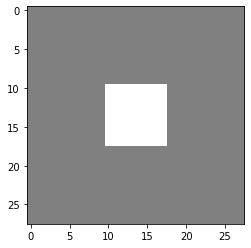

In [4]:
plt.figure()
plt.imshow(synthesized_image, cmap="gray", vmin=0, vmax=255)
plt.show()

The synthesized image is a gray 28x28 square with the white square in the middle. As with before, representation matters. We'll flatten this image into a 784-dimensional vector.

In [5]:
synthesized_image_flattened = synthesized_image.reshape(-1)
print(synthesized_image_flattened.shape)

(784,)


Now, we will corrupt this image by adding a noise to each pixel at random.

In [6]:
synthesized_image_noised = synthesized_image_flattened + np.random.normal(0, 4, synthesized_image_flattened.shape)

What does the corrupted image look like?

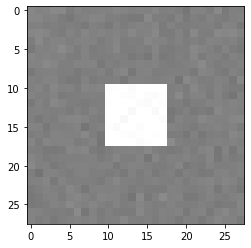

In [7]:
plt.figure()
plt.imshow(synthesized_image_noised.reshape(28, 28), cmap="gray", vmin=0, vmax=255)
plt.show()

Q: Where do we see these kinds of "corruptions" in real life?

Now, convince yourselves that `synthesized_image_flattened` is your target, and `synthesized_image_noised` is your input. In other words, we want to "predict" the un-noised version from the noised version of the image.

## Pop Quiz

Q: What are the two main components of an autoencoder?

In [8]:
encoder = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
)

In [9]:
synthesized_image_noised_tensor = torch.tensor(synthesized_image_noised / 255.).float()
embedding_tensor = encoder.forward(synthesized_image_noised_tensor)
print(embedding_tensor.shape)

torch.Size([256])


Q: What is `embedding_tensor`?

* A. the smaller version of the noisy image
* B. some garbage 10-dimensional vector
* C. none of the above

In [10]:
print(embedding_tensor)

tensor([0.1116, 0.0000, 0.0000, 0.0000, 0.0604, 0.0000, 0.1414, 0.1628, 0.2204,
        0.0285, 0.2796, 0.0000, 0.1879, 0.1302, 0.0000, 0.0259, 0.0505, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0887, 0.0392, 0.1131, 0.0000, 0.0000,
        0.0000, 0.0795, 0.1883, 0.0991, 0.0000, 0.0000, 0.0000, 0.0252, 0.1778,
        0.0594, 0.0717, 0.0000, 0.0310, 0.0322, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1161, 0.0586, 0.0780, 0.2893, 0.0390, 0.1886, 0.0881, 0.0000, 0.0126,
        0.0000, 0.1064, 0.0336, 0.0000, 0.0000, 0.0000, 0.0581, 0.0151, 0.1726,
        0.2800, 0.0713, 0.0710, 0.0000, 0.0000, 0.1677, 0.0643, 0.0209, 0.0000,
        0.1059, 0.0000, 0.0505, 0.0000, 0.2672, 0.0000, 0.0000, 0.1103, 0.0000,
        0.2365, 0.0151, 0.0000, 0.0000, 0.1556, 0.1097, 0.0000, 0.0000, 0.0000,
        0.0918, 0.0508, 0.0000, 0.0000, 0.0000, 0.1215, 0.1836, 0.0000, 0.0730,
        0.1725, 0.0501, 0.0830, 0.0556, 0.0000, 0.0000, 0.0000, 0.0000, 0.0276,
        0.0000, 0.0366, 0.0000, 0.0000, 

Q: Do you notice any pattern in the numbers inside `embedding_tensor`? What would be the reason for this?

In [11]:
decoder = nn.Sequential(
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 784),
)

In [12]:
predicted_image_flattened_tensor = decoder.forward(embedding_tensor) * 255.

In [13]:
print(predicted_image_flattened_tensor.shape)

torch.Size([784])


What does the prediction look like?

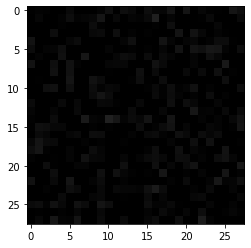

In [14]:
plt.figure()
plt.imshow(predicted_image_flattened_tensor.cpu().detach().numpy().reshape(28, 28), cmap="gray", vmin=0, vmax=255)
plt.show()

Not so good! Of course, it's because the NN hasn't learned anything yet. Let's cook up a quick training loop:

In [15]:
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(lr=3e-4, params=list(encoder.parameters()) + list(decoder.parameters()))

In [16]:
for _ in tqdm(range(1000)):
    # get data (i.e. input and target)
    synthesized_image = synthesize()
    synthesized_image_flattened = synthesized_image.reshape(-1)
    synthesized_image_flattened_tensor = torch.tensor(synthesized_image_flattened).float()
    synthesized_image_noised = synthesized_image_flattened + np.random.normal(0, 4, synthesized_image_flattened.shape)
    synthesized_image_noised_tensor = torch.tensor(synthesized_image_noised).float()

    embedding_tensor = encoder.forward(synthesized_image_noised_tensor / 255.)  # to keep input and output magnitudes low, I do manual "normalization" like this
    predicted_image_flattened_tensor = decoder.forward(embedding_tensor) * 255.
    
    loss = mse_loss.forward(predicted_image_flattened_tensor, synthesized_image_flattened_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 558.29it/s]


In [17]:
synthesized_image = synthesize()
synthesized_image_flattened = synthesized_image.reshape(-1)
synthesized_image_flattened_tensor = torch.tensor(synthesized_image_flattened).float()
synthesized_image_noised = synthesized_image_flattened + np.random.normal(0, 4, synthesized_image_flattened.shape)
synthesized_image_noised_tensor = torch.tensor(synthesized_image_noised).float()

In [18]:
embedding_tensor = encoder.forward(synthesized_image_noised_tensor / 255.)
predicted_image_flattened_tensor = decoder.forward(embedding_tensor) * 255.

Let's see how well our NN gets rid of the noise!

<Figure size 432x288 with 0 Axes>

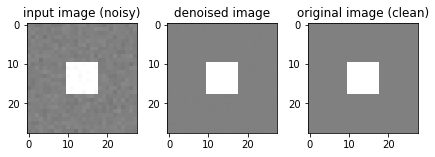

In [19]:
plt.figure()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(synthesized_image_noised.reshape(28,28), cmap="gray", vmin=0, vmax=255)
ax1.set_title("input image (noisy)")
ax2.imshow(predicted_image_flattened_tensor.cpu().detach().numpy().reshape(28, 28), cmap="gray", vmin=0, vmax=255)
ax2.set_title("denoised image")
ax3.imshow(synthesized_image, cmap="gray", vmin=0, vmax=255)
ax3.set_title("original image (clean)")
plt.tight_layout()
plt.show()

That's nice! But does it generalize to other sorts of images...?

## Autoencoder for Denoising Drawings

In the wild, denoising would be super convenient for "cleaning up" sketches, like the examples we see here:

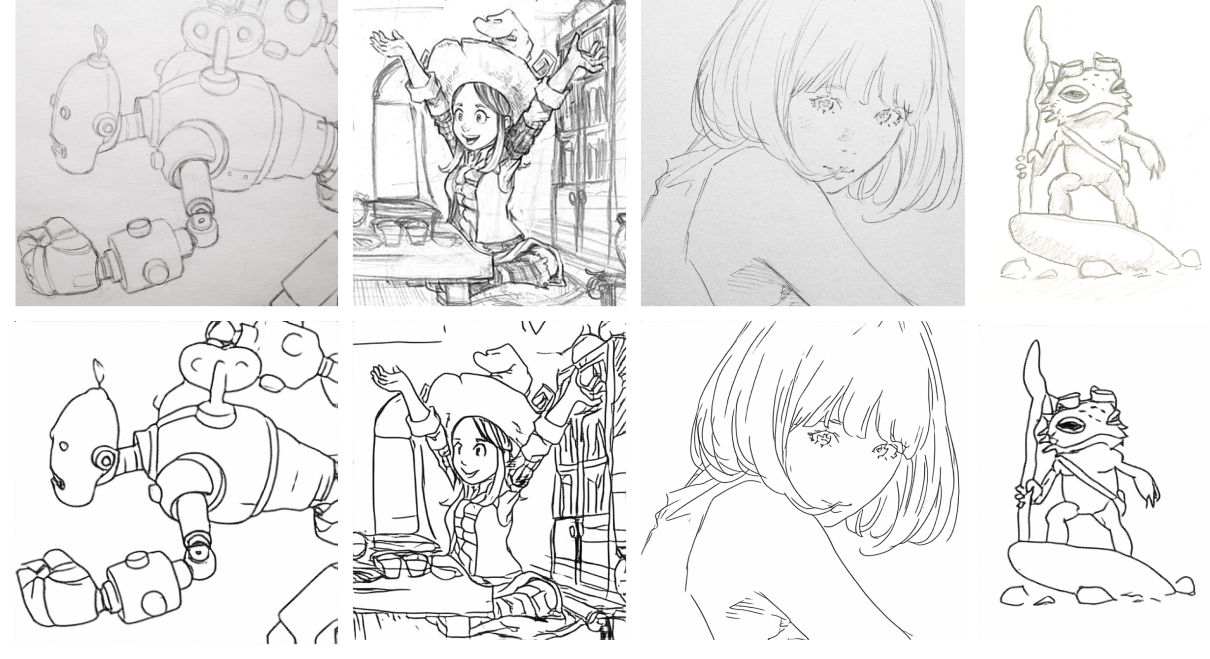

These images aren't publicly available due to copyright reasons, but we can mimick something like this, starting with a clean drawing.

In [20]:
class SketchDataset:
    
    def __init__(self, path, n_examples):
        self.path = path
        self.filenames = glob.glob(f"{path}/png/**/*.png")
        np.random.shuffle(self.filenames)
        self.filenames = self.filenames[:n_examples]
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):
        image_array = cv2.imread(self.filenames[index], cv2.IMREAD_GRAYSCALE)
        image_array_resized = cv2.resize(image_array, (256, 256))
        return image_array_resized
        
        
class NoisedSketchDataset(SketchDataset):
    
    def __getitem__(self, index):
        image_array = super().__getitem__(index)
        return image_array, np.clip(image_array + np.random.normal(0, 20, image_array.shape), 0, 255)
    

In [21]:
dataset = NoisedSketchDataset("sketches_png/", 1)

In [22]:
len(dataset)

1

In [23]:
image_clean, image_noised = dataset[0]

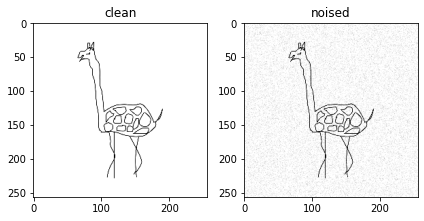

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image_clean, cmap="gray", vmin=0, vmax=255)
ax1.set_title("clean")
ax2.imshow(image_noised, cmap="gray", vmin=0, vmax=255)
ax2.set_title("noised")
plt.tight_layout()
plt.show()

Let's train our NN to denoise these drawings.

In [25]:
encoder = nn.Sequential(
    nn.Linear(65536, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
)
decoder = nn.Sequential(
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 65536),
)
optimizer = torch.optim.Adam(lr=3e-3, params=list(encoder.parameters()) + list(decoder.parameters()))

Note that `input_dim` is 256 * 256 = 65536. That's a pretty large number! Notice that I also increased the embedding size to 100, in case it's too small to be useful.

In [26]:
data_loader = DataLoader(dataset, batch_size=1)

In [27]:
for _ in tqdm(range(1000)):
    for images_clean, images_noised in data_loader:
        n_examples = images_clean.shape[0]
        images_clean_flattened = images_clean.reshape(n_examples, -1).float()
        images_noised_flattened = images_noised.reshape(n_examples, -1).float()

        # for gpu acceleration
        encoder = encoder.cuda()
        decoder = decoder.cuda()
        images_clean_flattened = images_clean_flattened.cuda()
        images_noised_flattened = images_noised_flattened.cuda()

        embeddings_tensor = encoder.forward(images_noised_flattened / 255.)
        predicted_images_flattened_tensor = decoder.forward(embeddings_tensor) * 255.

        loss = mse_loss.forward(predicted_images_flattened_tensor, images_clean_flattened)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
# undo gpu acceleration
encoder = encoder.cpu()
decoder = decoder.cpu()

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.13it/s]


<Figure size 432x288 with 0 Axes>

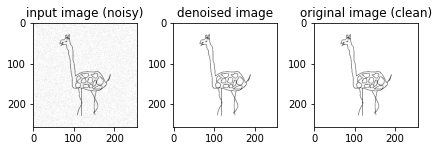

In [28]:
image_clean, image_noised = dataset[0]
image_clean_flattened_tensor = torch.tensor(image_clean).reshape(-1).float()
image_noise_flattened_tensor = torch.tensor(image_noised).reshape(-1).float()

embedding_tensor = encoder.forward(image_noise_flattened_tensor / 255.)
predicted_image_flattened_tensor = decoder.forward(embedding_tensor) * 255.

plt.figure()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(image_noised.reshape(256, 256), cmap="gray", vmin=0, vmax=255)
ax1.set_title("input image (noisy)")
ax2.imshow(predicted_image_flattened_tensor.cpu().detach().numpy().reshape(256, 256), cmap="gray", vmin=0, vmax=255)
ax2.set_title("denoised image")
ax3.imshow(image_clean.reshape(256, 256), cmap="gray", vmin=0, vmax=255)
ax3.set_title("original image (clean)")
plt.tight_layout()
plt.show()

Nice... 

But what if there were more than one images in the dataset?

In [29]:
encoder = nn.Sequential(
    nn.Linear(65536, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
)
decoder = nn.Sequential(
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 65536),
)
optimizer = torch.optim.Adam(lr=3e-3, params=list(encoder.parameters()) + list(decoder.parameters()))
dataset = NoisedSketchDataset("sketches_png/", 2)
data_loader = DataLoader(dataset, batch_size=1)
for _ in tqdm(range(1000)):
    for images_clean, images_noised in data_loader:
        n_examples = images_clean.shape[0]
        images_clean_flattened = images_clean.reshape(n_examples, -1).float()
        images_noised_flattened = images_noised.reshape(n_examples, -1).float()

        # for gpu acceleration
        encoder = encoder.cuda()
        decoder = decoder.cuda()
        images_clean_flattened = images_clean_flattened.cuda()
        images_noised_flattened = images_noised_flattened.cuda()

        embeddings_tensor = encoder.forward(images_noised_flattened / 255.)
        predicted_images_flattened_tensor = decoder.forward(embeddings_tensor) * 255.

        loss = mse_loss.forward(predicted_images_flattened_tensor, images_clean_flattened)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
# undo gpu acceleration
encoder = encoder.cpu()
decoder = decoder.cpu()

100%|█████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.68it/s]


<Figure size 432x288 with 0 Axes>

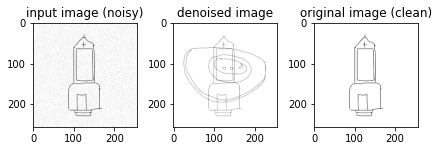

<Figure size 432x288 with 0 Axes>

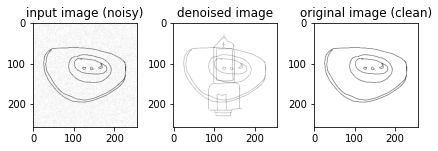

In [30]:
for i in range(2):
    image_clean, image_noised = dataset[i]
    image_clean_flattened_tensor = torch.tensor(image_clean).reshape(-1).float()
    image_noise_flattened_tensor = torch.tensor(image_noised).reshape(-1).float()

    embedding_tensor = encoder.forward(image_noise_flattened_tensor / 255.)
    predicted_image_flattened_tensor = decoder.forward(embedding_tensor) * 255.

    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(image_noised.reshape(256, 256), cmap="gray", vmin=0, vmax=255)
    ax1.set_title("input image (noisy)")
    ax2.imshow(predicted_image_flattened_tensor.cpu().detach().numpy().reshape(256, 256), cmap="gray", vmin=0, vmax=255)
    ax2.set_title("denoised image")
    ax3.imshow(image_clean.reshape(256, 256), cmap="gray", vmin=0, vmax=255)
    ax3.set_title("original image (clean)")
    plt.tight_layout()
    plt.show()

Looks like the NN is just learning to draw all the images on a white background, which actually helps minimize the loss, but not in the way we want. This tells me that a more expressive and smarter architecture is needed.

## Why Not Make the NN Deeper?

Earlier, we had our encoder and decoder initialized as 2-layer NNs, which are admittedly not that deep. One may suggest making the NNs deeper, i.e. add more layers. 

In [31]:
encoder = nn.Sequential(
    nn.Linear(65536, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
)
decoder = nn.Sequential(
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 65536),
)
optimizer = torch.optim.Adam(lr=3e-3, params=list(encoder.parameters()) + list(decoder.parameters()))
for _ in tqdm(range(1000)):
    for images_clean, images_noised in data_loader:
        n_examples = images_clean.shape[0]
        images_clean_flattened = images_clean.reshape(n_examples, -1).float()
        images_noised_flattened = images_noised.reshape(n_examples, -1).float()

        # for gpu acceleration
        encoder = encoder.cuda()
        decoder = decoder.cuda()
        images_clean_flattened = images_clean_flattened.cuda()
        images_noised_flattened = images_noised_flattened.cuda()

        embeddings_tensor = encoder.forward(images_noised_flattened / 255.)
        predicted_images_flattened_tensor = decoder.forward(embeddings_tensor) * 255.

        loss = mse_loss.forward(predicted_images_flattened_tensor, images_clean_flattened)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
# undo gpu acceleration
encoder = encoder.cpu()
decoder = decoder.cpu()

100%|█████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 68.87it/s]


<Figure size 432x288 with 0 Axes>

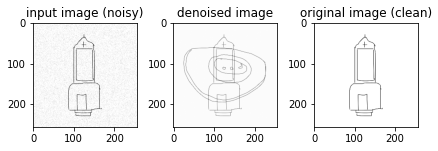

<Figure size 432x288 with 0 Axes>

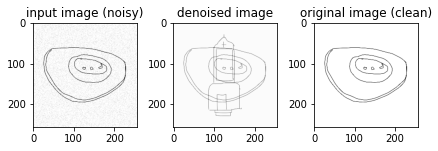

In [32]:
for i in range(2):
    image_clean, image_noised = dataset[i]
    image_clean_flattened_tensor = torch.tensor(image_clean).reshape(-1).float()
    image_noise_flattened_tensor = torch.tensor(image_noised).reshape(-1).float()

    embedding_tensor = encoder.forward(image_noise_flattened_tensor / 255.)
    predicted_image_flattened_tensor = decoder.forward(embedding_tensor) * 255.

    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(image_noised.reshape(256, 256), cmap="gray", vmin=0, vmax=255)
    ax1.set_title("input image (noisy)")
    ax2.imshow(predicted_image_flattened_tensor.cpu().detach().numpy().reshape(256, 256), cmap="gray", vmin=0, vmax=255)
    ax2.set_title("denoised image")
    ax3.imshow(image_clean.reshape(256, 256), cmap="gray", vmin=0, vmax=255)
    ax3.set_title("original image (clean)")
    plt.tight_layout()
    plt.show()

Looks like it didn't work... Why?

Well, two things that could cause fully-conncted networks to fail:
* Recall that fully-connected networks can be slow to optimize, so 1000 epochs may not be enough training!
* Just stacking more layers naively can end up causing numerical problems, so there's only little gains in expressivity.

## CNN to the Rescue

To address the limitations of the fully-connected networks, we'll use a similar architecture as this one:

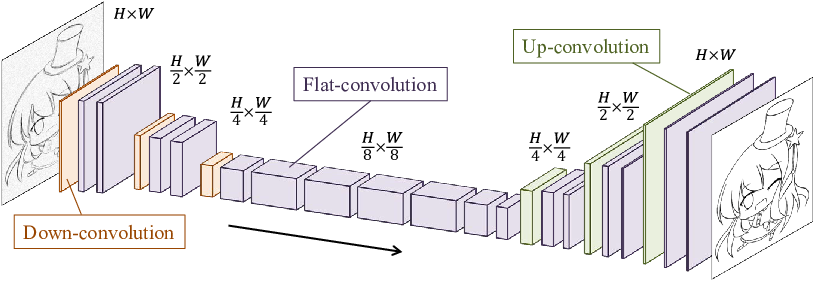

In [33]:
encoder = nn.Sequential(
    nn.Conv2d(1, 64, 5, 2, 1),  # down-convolution, 256x256 to 128x128
    nn.GroupNorm(1, 64, affine=False),
    nn.ReLU(),
    
    nn.Conv2d(64, 64, 3, 2, 1),  # down-convolution, 128x128 to 64x64
    nn.GroupNorm(1, 64, affine=False),
    nn.ReLU(),
    
    nn.Conv2d(64, 64, 3, 2, 1),  # down-convolution, 64x64 to 32x32
    nn.GroupNorm(1, 64, affine=False),
    nn.ReLU(),
)

decoder = nn.Sequential(
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
    nn.Conv2d(64, 64, 5, 1, 2),  # up-convolution, 32x32 to 64x64
    nn.GroupNorm(1, 64, affine=False),
    nn.ReLU(),

    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
    nn.Conv2d(64, 64, 5, 1, 2),  # up-convolution, 64x64 to 128x128
    nn.GroupNorm(1, 64, affine=False),
    nn.ReLU(),
    
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
    nn.Conv2d(64, 1, 5, 1, 2),  # up-convolution, 128x128 to 256x256
)


optimizer = torch.optim.Adam(lr=3e-4, params=list(encoder.parameters()) + list(decoder.parameters()))

In [34]:
image_noised_tensor = torch.tensor(image_noised).float()

In [35]:
image_noised_tensor.shape

torch.Size([256, 256])

In [36]:
embeddings = encoder.forward(image_noised_tensor.reshape(1, 1, *image_noised_tensor.shape))

In [37]:
embeddings.shape

torch.Size([1, 64, 32, 32])

In [38]:
predicted_image_tensor = decoder.forward(embeddings)

In [39]:
predicted_image_tensor.shape

torch.Size([1, 1, 256, 256])

In [40]:
for _ in tqdm(range(1000)):
    for images_clean, images_noised in data_loader:
        n, h, w = images_noised.shape
        images_clean_tensor = images_clean.reshape(n, 1, h, w).float()
        images_noised_tensor = images_noised.reshape(n, 1, h, w).float()

        # for gpu acceleration
        encoder = encoder.cuda()
        decoder = decoder.cuda()
        images_clean_tensor = images_clean_tensor.cuda()
        images_noised_tensor = images_noised_tensor.cuda()
        
        embeddings_tensor = encoder.forward(images_noised_tensor / 255.)
        predicted_images_tensor = decoder.forward(embeddings_tensor) * 255.
        
        loss = mse_loss.forward(predicted_images_tensor, images_clean_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
# undo gpu acceleration
encoder = encoder.cpu()
decoder = decoder.cpu()

100%|█████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 62.14it/s]


<Figure size 432x288 with 0 Axes>

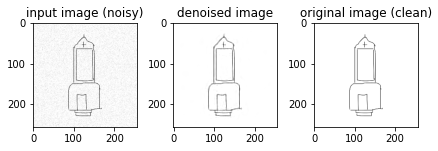

<Figure size 432x288 with 0 Axes>

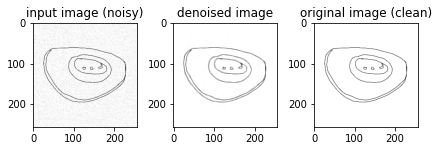

In [41]:
for i in range(2):
    image_clean, image_noised = dataset[i]
    h, w = image_noised.shape
    image_clean_tensor = torch.tensor(image_clean).float()
    image_noised_tensor = torch.tensor(image_noised).float()

    embedding_tensor = encoder.forward(image_noised_tensor.reshape(1, 1, h, w) / 255.)
    predicted_image_tensor = decoder.forward(embedding_tensor) * 255.

    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(image_noised, cmap="gray", vmin=0, vmax=255)
    ax1.set_title("input image (noisy)")
    ax2.imshow(predicted_image_tensor.cpu().detach().numpy().reshape(256, 256), cmap="gray", vmin=0, vmax=255)
    ax2.set_title("denoised image")
    ax3.imshow(image_clean, cmap="gray", vmin=0, vmax=255)
    ax3.set_title("original image (clean)")
    plt.tight_layout()
    plt.show()

Well, that's a start! Looks like there are issues with line tickness, but the NN is learning how to form edges without the noise.

# Notes:

* The proposed autoencoder architecture could be improved further by using more advanced techniques, e.g. introducing skip-connections or attention layers, and training for much longer (training for 12+ hours is normal!).
* Looking at the examples used for training actually gives you a very poor measure of the model's general performance, but for the sake of demo, we're not going to talk about the trickier side of machine learning.